<a href="https://colab.research.google.com/github/brianshin12/zeta/blob/master/Chapter_4_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%ED%95%99%EC%8A%B5%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
import os
sys.path.insert(0, '/content/gdrive/My Drive')
from mnist import load_mnist 
import numpy as np
import matplotlib.pylab as plt

# 신경망 학습  

* 학습  
    훈련 데이터로부터 가중치 매개변수의 최적값을 자동으로 획득하는 것을 뜻합니다.  
* 손실 함수
    신경망이 학습할 수 있도록 해주는 지표  
    손실 함수의 결괏값을 가장 작게 만드는 가중치 매개변수를 찾는 것이 목표  

## 4.1 데이터에서 학습한다!  

* 신경망의 특징: 데이터를 보고 학습, 가중치 매개변수의 값을 데이터를 보고 자동으로 결정  

### 4.1.1 데이터 주도 학습  

* 기계학습의 핵심: 데이터, 사람의 개입을 최소화 수집한 데이터로부터 패턴 발견  
    Ex)'5'를 분류하는 프로그램
    * 알고리즘을 밑바닥부터 설계하는 대신, 주어진 데이터를 잘 활용  
    신경망: 이미지에 포함된 중요한 특징까지 있는 그대로 학습.(종단간 기계학습)  
    
### 4.1.2 훈련데이터와 시험데이터  

* 훈련데이터&시험데이터  
    * 훈련데이터: 훈련데이터만을 이용하여 최적의 매개변수를 찾는다.
    * 시험데이터: 시험데이터를 사용하여 앞서 훈련한 모델의 실력을 평가, 범용능력을 평가  
    * 오버피팅: 한 데이터셋에만 지나치게 최적화된 상태
    
## 4.2 손실 함수  

* 신경망 학습에서는 현재의 상태를 '하나의 지표'(손실 함수)로 표현  
    그 지표(손실 함수)를 가장 좋게 만들어주는 가중치 매개변수의 값을 탐색  
    일반적으로 편균 제곱 오차와 교차 엔트로피 오차 사용  
    
### 4.2.1 평균 제곱 오차  
$$E = {\sum_{}^{} ({y_k-t_k})^2\over2}$$  
* y: 신경망이 추정한 값
* t: 정답 레이블
* k: 데이터 차원 수

In [0]:
def mean_squared_error(y,t):
    return 0.5*np.sum((y-t)**2)

t=[0,0,1,0,0,0,0,0,0,0] #정답은 2
y=[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0] #'2'일 확률이 가장 높다고 추정 (소프트맥스 함수의 출력)
mean_squared_error(np.array(y), np.array(t)) #아래의 예시보다 오차가 더 작다, 정답에 더 가까울 것으로 판단

0.09750000000000003

In [0]:
y=[0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0] #'7'일 확률이 가장 높다고 추정 
mean_squared_error(np.array(y), np.array(t))

0.5975

### 4.2.2 교차 엔트로피 오차  
$$E = {-\sum_{}^{} t_k ln y_k}$$  
* y:신경망의 출력  
* t:정답 레이블  
    t: 정답에 해당하는 인덱스의 원소만 1이고 나머지는 0 (원-핫 인코딩)

In [0]:
def cross_entropy_error(y,t):
    delta=1e-7 #마이너스 무한대 방지
    return -np.sum(t*np.log(y+delta))

t=[0,0,1,0,0,0,0,0,0,0]
y=[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [0]:
y=[0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

### 4.2.3 미니배치 학습  
* 훈련 데이터 모두에 대한 손실함수의 합
$$E = {-{1 \over N} \times \sum_{n}^{} \sum_{k}^{} t_{nk} ln y_{nk}}$$  

* 많은 데이터를 대상으로 일일이 손실 함수를 계산하는 것은 현실적이지 않다.  
    데이터를 일부 추려 전체의 '근사치'로 이용 → 미니배치 학습

In [0]:
#mnist dataset을 읽어오는 코드
(x_train, t_train), (x_test, t_test)=\
    load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape) #훈련 데이터는 60000개, 입력 데이터는 784열
print(t_train.shape) #정답 레이블은 10줄 따리 데이터

(60000, 784)
(60000, 10)


In [0]:
#무작위로 10장만 빼내는 코드
train_size=x_train.shape[0]
batch_size=10
batch_mask=np.random.choice(train_size, batch_size)
x_batch=x_train[batch_mask]
t_batch=t_train[batch_mask]

np.random.choice(60000,10)

array([14368, 36262,   495, 15985, 12520, 56327, 38631, 22980, 15783,
       22794])

### 4.2.4 (배치용) 교차 엔트로피 오차 구현하기  

In [0]:
def cross_entropy_error(y,t):
    if y.ndim==1:
        t=t.reshape(1, t.size)
        y=y.reshape(1, y.size)
        
    bath_size=y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size),t]+1e-7))/batch_size

* y: 신경망 출력  
    y가 1차원이라면(데이터 하나당 교차 엔트로피 오차를 구하는 경우) reshape 함수로 데이터 형상을 바꿔줍니다.  
    배치의 크기로 나눠 정규화하고 이미지 1장당 평균의 교차 엔트로피 오차를 계산합니다.
* t: 정답 레이블

### 4.2.5 왜 손실 함수를 설정하는가?  

* 궁극적인 목표: 높은 '정확도'를 끌어내는 매개변수 값을 찾는 것.  
* 신경망 학습에서의 '미분'의 역할에 주목  
    최적의 매개변수를 탐색 → 손실 함수의 값을 가능한 작게하는 매개변수 값을 찾음  
    →매개병수의 미분 값을 단서로 매개변수의 값을 갱신하는 과정 반복
* 미분 값이 음수이면 가중치 매개변수를 양의 방향으로 변화시켜 손실 함수의 값을 줄임  
    미분 값이 양수이면 가중치 매개변수를 음의 방향으로 변화시켜 손실 함수의 값을 줄임  
* 미분 값이 0 이면 가중치 매개변수의 갱신 멈춤 → '정확도'가 아닌 '손실 함수의 값'을 지표로 삼는 이유  
    Ex1) 100장의 훈련 데이터 중 32장을 올바로 인식  
    이때 정확도는 32%이지만 매개변수를 약간만 조정해서는 정확도가 개선되지 않고 개선된다 하더라도 불연속적인 값으로 바뀜  
    '계단 함수'를 활성화 함수로 사용하지 않는 이유와도 일치

## 4.3 수치미분  
### 4.3.1 미분  
* 파이썬에서 미분을 곧대로 구현하면 2가지 개선 사항이 있습니다.  

1) 0으로 무한히 가까운 수를 대입하려고 매우 작은 수를 대입하면 반올림 오차 문제를 일으킵니다.  
반올림 오차는 작은 값(소수점 8자리 이하)이 생략되어 최종 계산 결과에 오차가 생기게 합니다.  
이 미세한 값으로 10^-4 정도의 값을 사용하면 좋은 결과를 얻는다고 알려져 있습니다.

In [0]:
np.float32(1e-50)

0.0

2) 두번 째 개선사항으로는 차분, 즉 임의의 두점에서의 함수 값들의 차이와 관련한 것입니다.  
진정한 접선과 (x+h)와 x사이의 기울기는 엄밀히 일치하지 않습니다.  
그에 따른 오차를 줄이기 위해 (x+h), (x-h) 일 때의 함수의 차분을 계산하는 방법을 쓰기도 합니다.(중심차분, 중앙 차분)

In [0]:
def numerical_diff(f,x):
  h=1e-4
  return (f(x+h)-f(x-h))/2*h

### 4.3.2 수치 미분의 예  
 * 수치 미분의 간단한 예  
 $$y=0.01x^2+0.1x$$

In [0]:
def function_1(x):
  return 0.01*x**2+0.1*x

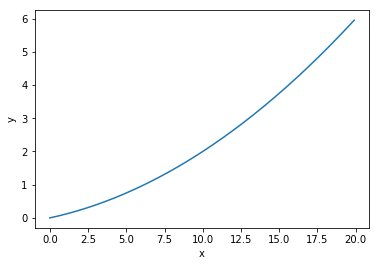

In [0]:
x=np.arange(0.0, 20.0, 0.1)
y=function_1(x)
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x,y)
plt.show()

In [0]:
numerical_diff(function_1, 5)

1.9999999999908982e-09

In [0]:
numerical_diff(function_1, 10)

2.999999999986347e-09

이렇게 계산한 미분 값이 x에 대한 f(x)의 변화량, 즉 기울기입니다. 다음의 코드를 통해 접선에 해당하는 것을 확인할 수 있습니다.

0.1999999999990898


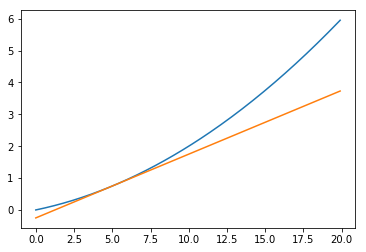

In [0]:
def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

tf = tangent_line(function_1, 5)
y2 = tf(x)
plt.plot(x, y)
plt.plot(x, y2)
plt.show()

### 4.3.3 편미분  
$$f(x_0,x_1)=x_0^2+x_1^2$$  
이러한 식은 앞의 예와 달리 변수가 2개 입니다.  
다음과 같이 구현할 수 있습니다.

In [0]:
def function_2(x):
  return x[0]**2+x[1]**2

편미분을 구하는 두 연습문제를 보겠습니다.

In [0]:
#x_0=3 x_1=4 일때 x_0에 대한 편미분
def function_tmp1(x0):
  return x0*x0  + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [0]:
 #x_0=3 x_1=4 일때 x_1에 대한 편미분
def function_tmp2(x1):
  return 3.0**2.0 + x1*x1

numerical_diff(function_tmp2, 4.0)

7.999999999999119

## 4.4 기울기  
x_0와 x_1의 편미분을 동시에 계산하는 방법  
기울기 : 모든 변수의 편미분을 벡터로 정리 한 것. 

In [0]:
def numerical_gradient(f,x):
  h=1e-4
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val=x[idx]

    x[idx]=tmp_val + h
    fxh1=f(x)

    x[idx]=tmp_val - h
    fxh2=f(x)

    grad[idx]= (fxh1-fxh2)/(2*h)
    x[idx]=tmp_val

  return grad

In [0]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [0]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [0]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

이 기울기를 그림으로 그려보면 다음과 같이 됩니다.  
기울기는 함수의 최솟값을 향하고 있고 최솟값에서 멀어질수록 화살표의 크기가 커짐을 알 수 있습니다.

No handles with labels found to put in legend.


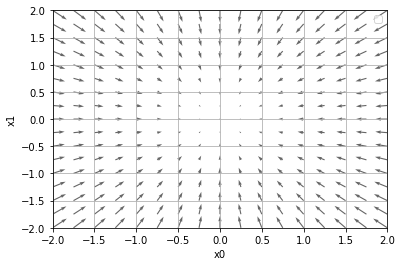

In [0]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.legend()
    plt.draw()
    plt.show()